This is a short guide on how machine learning can be used for chemistry applications.


We will take some ligands that are active against a protein target, as well as some decoy molecules, in this case FDA approved drugs.


We will use extended connectivity fingerprints (ECFPs), which are vectors of 1s and 0s that represent the presence or absence of features in a molecule.


They can take molecules of any size and convert them into vectors, where the corresponding elements can be compared.


The algorithm begins by looking at each atom independently and their properties, such as the element and number of bonds. Then it works outwards, considering groups of atoms which defines new sets of larger features.

First some imports

In [2]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

--2020-05-11 22:25:47--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2020-05-11 22:25:47--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  81.12M   125MB/s    in 0.7s    

2020-05-11 22:25:48 (125 MB/s) - ‘Miniconda3-latest-Linux

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import pandas as pd
import io
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from google.colab import files

In [0]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolsToGridImage

Next we will upload our data files. We will investigate target CHEMBL210, a beta-2 adrenergic receptor that interacts with adrenaline and mediates physiological response, with data from ChEMBL, a database of bioactive molecules.

Download the following data [here](https://www.ebi.ac.uk/chembl/embed/#target_report_card/CHEMBL210/ligand_efficiencies) for the target.

For the dummies, we will get a list of FDA drugs from Zinc, another small molecule database - [here](http://zinc.docking.org/substances/subsets/fda/).

Then upload the data as follows:

In [6]:
upload_210 = files.upload()

Saving Chembl210.csv to Chembl210.csv


In [0]:
df_210 = pd.read_csv(io.StringIO(upload_210['Chembl210.csv'].decode('utf-8')), sep = ';')

In [10]:
df_210.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1377 entries, 0 to 1376
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Molecule ChEMBL ID          1377 non-null   object 
 1   Molecule Name               177 non-null    object 
 2   Molecule Max Phase          1377 non-null   int64  
 3   Molecular Weight            1377 non-null   float64
 4   #RO5 Violations             1356 non-null   float64
 5   AlogP                       1356 non-null   float64
 6   Compound Key                1377 non-null   object 
 7   Smiles                      1377 non-null   object 
 8   Standard Type               1377 non-null   object 
 9   Standard Relation           1377 non-null   object 
 10  Standard Value              1377 non-null   float64
 11  Standard Units              1377 non-null   object 
 12  pChEMBL Value               1377 non-null   float64
 13  Data Validity Comment       0 non

We want to take the Smiles values, which uses text to describe the structure of chemical species.

In [0]:
smiles_210 = df_210['Smiles']

RDKIt is an open source python package that allows one to work with molecules. Here the smiles string can be converted into structures.

In [0]:
mols_210 = [Chem.MolFromSmiles(smiles) for smiles in smiles_210]

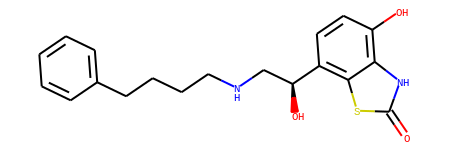

In [14]:
mols_210[0]

In [15]:
# Checking we have all our compounds, 1377 (at time of writing)
len(mols_210)

1377

Now do the same for the FDA compounds

In [17]:
upload_fda = files.upload()

Saving fda.csv to fda.csv


In [0]:
df_fda = pd.read_csv(io.StringIO(upload_fda['fda.csv'].decode('utf-8')), sep = ',')

In [0]:
smiles_fda = df_fda['smiles']

In [0]:
mols_fda = [Chem.MolFromSmiles(smiles) for smiles in smiles_fda]

In [21]:
# 1615 here
len(mols_fda)

1615

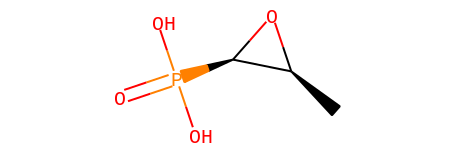

In [25]:
mols_fda[0]

Nowe we will use Morgan fingerprints, also known as circular fingerprints to featurize our structures. We are specifying the radius of the fingerprint to 3.

In [0]:
actives_210 = np.array([])
for mol in mols_210:
  Morgan3 = Chem.GetMorganFingerprintAsBitVect(mol, 3).ToBitString()
  Morgan3arr = np.array(list(map(int, Morgan3)))
  if len(actives_210) == 0:
    actives_210 = Morgan3arr
  else:
    actives_210 = np.vstack((actives_210, Morgan3arr))

In [27]:
actives_210.shape

(1377, 2048)

In [0]:
decoys_fda = np.array([])
for mol in mols_fda:
  Morgan3 = Chem.GetMorganFingerprintAsBitVect(mol, 3).ToBitString()
  Morgan3arr = np.array(list(map(int, Morgan3)))
  if len(decoys_fda) == 0:
    decoys_fda = Morgan3arr
  else:
    decoys_fda = np.vstack((decoys_fda, Morgan3arr))

In [31]:
decoys_fda.shape

(1615, 2048)

Now let's start training and testing our model using sklearn and logistic regression

In [0]:
PROP_TEST = 0.2

In [0]:
train_actives, test_actives = train_test_split(actives_210, test_size = PROP_TEST)
train_decoys, test_decoys = train_test_split(decoys_fda, test_size = PROP_TEST)

In [34]:
print(train_actives.shape)
print(test_actives.shape)
print(train_decoys.shape)
print(test_decoys.shape)

(1101, 2048)
(276, 2048)
(1292, 2048)
(323, 2048)


Below is our supervised training, where the ones denote a confirmed hit on the ligand and zeroes denote the decoys

In [0]:
train_X = np.vstack((train_actives, train_decoys))
test_X = np.vstack((test_actives, test_decoys))

train_Y = np.concatenate((np.ones((np.shape(train_actives)[0])), np.zeros((np.shape(train_decoys)[0]))))
test_Y = np.concatenate((np.ones((np.shape(test_actives)[0])), np.zeros((np.shape(test_decoys)[0]))))

In [39]:
print(train_X.shape)
print(test_X.shape)
print(train_Y.shape)
print(test_Y.shape)

(2393, 2048)
(599, 2048)
(2393,)
(599,)


In [0]:
lr = LogisticRegression(max_iter=1000)

In [41]:
lr.fit(train_X, train_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
pred_Y = lr.predict_proba(test_X)[:, 1] 

In [52]:
roc_auc_score(test_Y, pred_Y)

0.9856586799479518

Text(0.5, 1.0, 'Receiver Operating Characteristic Curve')

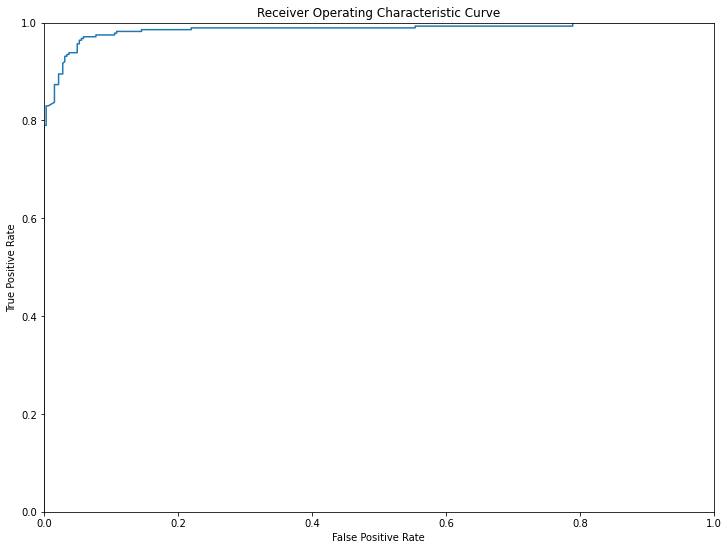

In [53]:
fpr, tpr, threshold = roc_curve(test_Y, pred_Y)
fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(fpr, tpr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title('Receiver Operating Characteristic Curve')

In [0]:
def morg(smiles):
  ### Converts smiles string to Morgan fingerprint ###
  mol = Chem.MolFromSmiles(smiles)
  Morgan3 = Chem.GetMorganFingerprintAsBitVect(mol, 3).ToBitString()
  Morgan3arr = np.array(list(map(int, Morgan3)))
  return Morgan3arr

In [55]:
smiles_210[1]

'O=c1[nH]c2c(O)ccc([C@@H](O)CN[C@H]3CCC[C@@H]3OCc3ccccc3)c2s1'

In [0]:
testmol = morg('O=c1[nH]c2c(O)ccc([C@@H](O)CN[C@H]3CCC[C@@H]3OCc3ccccc3)c2s1').reshape((1, 2048))

In [69]:
testmol.shape

(1, 2048)

In [0]:
pred_test = lr.predict_proba(testmol)[:, 1]

In [73]:
pred_test

array([0.99958847])